In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import hypergeom
from re import search
import csv

import sys
sys.path.append('../GOCAM_Project/dev')
import utils

In [2]:
#import the reactome data
data_reactome = pd.read_csv("~/Downloads/metabolic_gocams2genes_20220728.tsv", header=0, names=["gocam", "title", "identifier","taxon","taxon_labels","modelstate"], sep="\t")
data_reactome['identifier'] = data_reactome['identifier'].apply(lambda x: x.split(','))
data_reactome['taxon_labels'] = data_reactome['taxon_labels'].apply(lambda x: x.split(','))
data_reactome['title']=data_reactome['title'].apply(lambda x: x.split('^')[0])
data_reactome['modelstate']=data_reactome['modelstate'].apply(lambda x: x.split('^')[0])
data_reactome['gocam']=data_reactome['gocam'].apply(lambda x: x[1:len(x)-1])
data_reactome = data_reactome[data_reactome['taxon_labels'].apply(lambda x: 'Homo sapiens' in x)]
data_reactome = data_reactome[['gocam','title','identifier']]
data_reactome

,gocam,title,identifier
0,http://model.geneontology.org/R-HSA-997272,Inhibition of voltage gated Ca2+ channels via ...,[http://purl.obolibrary.org/obo/go/extensions/...
1,http://model.geneontology.org/R-HSA-1296041,Activation of G protein gated Potassium channe...,[http://purl.obolibrary.org/obo/go/extensions/...
2,http://model.geneontology.org/R-HSA-5218921,VEGFR2 mediated cell proliferation - imported ...,[http://purl.obolibrary.org/obo/go/extensions/...
3,http://model.geneontology.org/R-HSA-2871809,FCERI mediated Ca+2 mobilization - imported fr...,[http://purl.obolibrary.org/obo/go/extensions/...
4,http://model.geneontology.org/R-HSA-2029485,Role of phospholipids in phagocytosis - import...,[http://purl.obolibrary.org/obo/go/extensions/...
...,...,...,...
1082,http://model.geneontology.org/R-HSA-110312,Translesion synthesis by REV1 - imported from:...,[http://purl.obolibrary.org/obo/go/extensions/...
1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,"[http://identifiers.org/uniprot/Q9Y2B2, http:/..."
1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),"[http://identifiers.org/uniprot/Q8N884, http:/..."
1095,http://model.geneontology.org/5a5fc23a00000008,adenylate cyclase test 20180123,"[http://identifiers.org/uniprot/Q08828, http:/..."


In [3]:
data_reactome[data_reactome.identifier.apply(lambda x: 'http://purl.obolibrary.org/obo/go/extensions/reacto.owl#REACTO_R-HSA-186821' in x)]

,gocam,title,identifier


In [4]:
#import the production data
data = pd.read_csv("~/Downloads/gocams2genes_20220728.txt", header=0, names=["gocam", "title", "gp_labels","identifier","taxon","taxon_label","modelstate"], sep="\t")
data['gp_labels'] = data['gp_labels'].apply(lambda x: x.split(','))
data['identifier'] = data['identifier'].apply(lambda x: x.split(','))
data['title']=data['title'].apply(lambda x: x.split('^')[0])
data['modelstate']=data['modelstate'].apply(lambda x: x.split('^')[0])
data['gocam']=data['gocam'].apply(lambda x: x[1:len(x)-1])
data_human = data[data['taxon_label'].apply(lambda x: ('Mus musculus' not in x) and ('Homo sapiens' in x))]
mouse = data[data.taxon_label.apply(lambda x: ('Mus musculus' in x) and ('Homo sapiens' not in x))]
data_human = data_human[['gocam','title','identifier']]
data_both = data[data.taxon_label.apply(lambda x: ('Mus musculus' in x)and ('Homo sapiens' in x))]
len(data_both.identifier.values[0])

37

In [5]:
mouse = mouse.explode('identifier')
mouse.identifier.apply(lambda x: x.split('/')[-2]).value_counts()

mgi    482
obo      1
Name: identifier, dtype: int64

In [6]:
mouse_mgi = mouse[mouse.identifier.apply(lambda x: 'MGI:' in x)]
mouse_non_mgi = mouse[mouse.identifier.apply(lambda x: 'MGI:' not in x)]
mouse_mgi.identifier = mouse_mgi.identifier.apply(lambda x: x.split('/')[-1])

table = pd.read_csv('../data/simplemine_results.txt',sep='\t', header=3)
table['Mouse Ortholog'] = table['Mouse Ortholog'].apply(lambda x: x.split(' | '))
table = table.explode('Mouse Ortholog')
d= pd.Series(table['UniProtKB ID'].values,index=table['Mouse Ortholog'].apply(lambda x: x[:x.rfind(":")])).to_dict()
mouse_mgi['h_uniprot'] = mouse_mgi.identifier.apply(lambda x: d.get(x,'NO ORTHOLOG FOUND'))
mouse_mgi = mouse_mgi[mouse_mgi["h_uniprot"] != 'N.A.']
#just picking the first uniprot entry, because the canonical one isn't indicated in the simplemine results
mouse_mgi['identifier']=mouse_mgi['h_uniprot'].apply(lambda x: 'http://identifiers.org/uniprot/'+x.split(' | ')[0])
mouse_mgi = mouse_mgi[['gocam','title','identifier']]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [7]:
mouse_mgi.query('gocam== "http://model.geneontology.org/60418ffa00001124"')

,gocam,title,identifier
62,http://model.geneontology.org/60418ffa00001124,Hypoxanthine catabolic process (Mouse),http://identifiers.org/uniprot/P47989
62,http://model.geneontology.org/60418ffa00001124,Hypoxanthine catabolic process (Mouse),http://identifiers.org/uniprot/A6NGE7


In [8]:
#There are 4 models in the reactome file that don't appear to be actually from reactome
data_reactome_cleaned = data_reactome[data_reactome['gocam'].apply(lambda x: '/R-' in x)]

The next two cells verify that all cases of uniprot IDs from the metabolic models tsv are from these 4 non-reactome gocams

In [9]:
data_reactome = data_reactome.explode('identifier')
data_reactome.reset_index(inplace=True)
data_reactome[data_reactome['gocam'].apply(lambda x: 'R-' not in x)]

,index,gocam,title,identifier
5315,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/Q9Y2B2
5316,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/Q7Z7B1
5317,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/P37287
5318,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/Q9H3S5
5319,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/O60762
5320,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q8N884
5321,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q86WV6
5322,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q92993-4
5323,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q9NSU2-3
5324,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q96GD4-1


In [10]:
data_reactome[data_reactome['identifier'].apply(lambda x: 'uniprot' in x)]

,index,gocam,title,identifier
5315,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/Q9Y2B2
5316,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/Q7Z7B1
5317,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/P37287
5318,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/Q9H3S5
5319,1090,http://model.geneontology.org/596a6e0600000152,GPI1_human_PD,http://identifiers.org/uniprot/O60762
5320,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q8N884
5321,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q86WV6
5322,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q92993-4
5323,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q9NSU2-3
5324,1092,http://model.geneontology.org/613aae0000000061,cGAS-STING (Human),http://identifiers.org/uniprot/Q96GD4-1


In [11]:
#not used (utils.update_dict used instead... i think)
def build_dict (data): #data= dataframe with gocam IDs and gene identifiers as columns
    Dict = {}
    for index, row in data.iterrows():
        gene = row['identifier']
        gocam = row['gocam']
        if (gene in Dict) == False:
            Dict[gene]={gocam}
        else:
            prev = Dict.get(gene)
            prev.add(gocam)
            Dict[gene] = prev
    return Dict

In [12]:
uIDs = utils.csv2dict('../data/uIDs.csv')

In [13]:
#needed to update identifiers.csv after importing the new reactome models... dependence of the reactome2uniprot notebook on this line is bad
#data2matrix(data_reactome_cleaned).identifier.to_csv('../data/identifiers.csv')

In [14]:
#expand rows
data_reactome = data_reactome_cleaned.explode('identifier')
data_reactome.reset_index(inplace=True)
data_ = pd.concat([data_human.explode('identifier'),mouse_mgi])
data_.reset_index(inplace=True)

#data_reactome = data2matrix(data_reactome_cleaned)
#data_ = data2matrix(data)

#KEEP ONLY UNIPROT, GO COMPLEX
data_uniprot = data_[data_.identifier.apply(lambda x: 'uniprot' in x) ]
data_uniprot.identifier = data_uniprot.identifier.apply(lambda x: x.split('/')[-1])
data_GOcomplex = data_[data_.identifier.apply(lambda x: 'obo/GO_' in x) ]

#map IDs using uIDs dictionary
data_reactome['uniprot']=data_reactome['identifier'].apply(lambda x: uIDs.get(x,'NOT FOUND'))
num_before = len(data_reactome)
not_mapped = data_reactome[data_reactome['uniprot'] == 'NOT FOUND']
data_reactome = data_reactome[data_reactome['uniprot'] != 'NOT FOUND'] 
num_lost = num_before - len(data_reactome)
data_reactome['identifier'] = data_reactome['uniprot']
data_reactome = data_reactome.drop('uniprot',axis=1)
num_lost

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


46

In [15]:
not_mapped.identifier.apply(lambda x: x.split('REACTO_')[-1]).unique()

array(['R-HSA-169696', 'R-HSA-2024024', 'R-HSA-166763', 'R-HSA-173759',
       'R-HSA-174383', 'R-HSA-453132', 'R-HSA-202877', 'R-HSA-8957329',
       'R-HSA-1250221', 'R-HSA-750994', 'R-HSA-8874682', 'R-HSA-8853807',
       'R-HSA-500310', 'R-HSA-2869445', 'R-HSA-9710124', 'R-HSA-420974',
       'R-HSA-420976', 'R-HSA-975268'], dtype=object)

In [16]:
data_reactome = data_reactome.explode('identifier')
data_reactome.reset_index(inplace=True)
data_reactome.title = data_reactome.title.apply(lambda x : x.replace("imported from: Reactome","Reactome"))
#data_reactome = data2matrix(data_reactome)

In [17]:
data_final = pd.concat([data_uniprot,data_reactome])
data_final = data_final[['gocam','title','identifier']]
data_final.identifier = data_final.identifier.apply(lambda x: x.split('/')[-1])
data_final.to_csv('../data/data_final_mouse.csv')
modelID2title = pd.Series(data_final.title.values,index=data_final.gocam)
modelID2title.to_csv('../data/modelID2title_mouse.csv')
data_final


,gocam,title,identifier
0,http://model.geneontology.org/627d95ee00000024,IL12-mediated signaling pathway (Human),P29597
1,http://model.geneontology.org/627d95ee00000024,IL12-mediated signaling pathway (Human),Q14765
2,http://model.geneontology.org/627d95ee00000024,IL12-mediated signaling pathway (Human),P29459
3,http://model.geneontology.org/627d95ee00000024,IL12-mediated signaling pathway (Human),P29460
4,http://model.geneontology.org/627d95ee00000024,IL12-mediated signaling pathway (Human),P42701
...,...,...,...
11278,http://model.geneontology.org/R-HSA-110312,Translesion synthesis by REV1 - Reactome,O60673
11279,http://model.geneontology.org/R-HSA-110312,Translesion synthesis by REV1 - Reactome,Q9UI95
11280,http://model.geneontology.org/R-HSA-110312,Translesion synthesis by REV1 - Reactome,P63146
11281,http://model.geneontology.org/R-HSA-110312,Translesion synthesis by REV1 - Reactome,Q9NS91


In [18]:
len(data_final[data_final.title.apply(lambda x: ('mouse' in x) or ('Mouse' in x))].title.unique())

76

([<matplotlib.axis.XTick at 0x7f8d93df1510>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

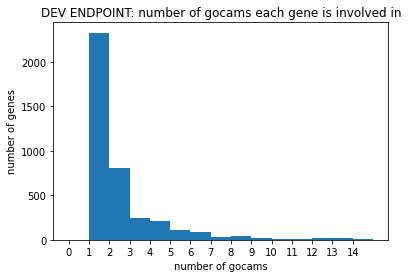

In [19]:
D = {}
D = utils.update_dict(D, data_final[['gocam','identifier']],'identifier','gocam')
x = []
for key in D:
    num_gocams = len(D.get(key))
    x.append(num_gocams)
plt.hist(x, bins=15, range=(0,15))
plt.xlabel("number of gocams")
plt.ylabel("number of genes")
plt.title("DEV ENDPOINT: number of gocams each gene is involved in")
plt.xticks(np.arange(0,15))

In [20]:
def get_sizes (data): #data= dataframe with gocam IDs and gene identifiers as columns
    return data['gocam'].value_counts()
    

In [21]:
def filter_gene_list(gene_list, Dict):
    filtered_gene_list = []
    for gene in gene_list:
        if gene in Dict:
            filtered_gene_list.append(gene)
    return filtered_gene_list

In [22]:
def count_genes(gene_list, Dict):
    gocam_counts = {} #key=gocam, value=list of genes in gocam that are also in the user's list
    for g in gene_list: 
            gocams = Dict.get(g)
            for gocam in gocams:
                if (gocam in gocam_counts) == False:
                    gocam_counts[gocam]=[g]
                else:
                    prev = gocam_counts.get(gocam)
                    prev.append(g)
                    gocam_counts[gocam] = prev
    return gocam_counts

In [23]:
# APPLY BENJAMINI HOCHBERG CORRECTION in correct_pval_and_format()
def hgt(counts, gocam_sizes, alpha, gene_list_size, background_gene_list_size):
    results = []
    for gocam, gene_list in counts.items():
        count = len(gene_list) 
        gocam_size = gocam_sizes[gocam]
        pvalue = hypergeom.sf(count-1, background_gene_list_size,  gocam_size, gene_list_size) 
        if pvalue < alpha:
            r = (gocam, pvalue, count, gocam_size, gene_list )
            results.append(r)
    return results

In [24]:
def fdr(rank,num_tests,alpha):
    return (rank*alpha/num_tests)

In [25]:
#Benjamini Hochberg correction
def correct_pval_and_format(enriched_gocams, background_num_gocams):
    df = pd.DataFrame(enriched_gocams, columns =['Name', 'pval (uncorrected)', '# genes in list','#genes in gocam','shared genes in gocam'])
    df.sort_values('pval (uncorrected)',inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['FDR_val'] = (df.index+1)*.05/background_num_gocams
    df['Less_than'] = (df['pval (uncorrected)'] < df['FDR_val'])
    index = df.Less_than.where(df.Less_than==True).last_valid_index()
    df_significant = df.loc[0:index]
    df_display = df_significant[['Name','pval (uncorrected)', '# genes in list', '#genes in gocam','shared genes in gocam']]
    return(df_display)

In [26]:
#as of now, Dict can only contain 1 instance of each gene per gocam (no duplicates)
#SURVIVAL FUNCTION, NOT PMF
def enrich(gene_list,gocam_sizes, Dict):
    background_gene_list_size = len(Dict)
    gene_list_filtered = filter_gene_list(gene_list, Dict) #need to clean gene_list to only include genes in the gocam
    gene_list_size = len(gene_list_filtered) #the size of the user's gene list AFTER filtering
    counts = count_genes(gene_list_filtered, Dict)
    enriched_gocams = hgt(counts, gocam_sizes, .05, gene_list_size, background_gene_list_size)
    background_num_gocams = len(gocam_sizes)
    df_display = correct_pval_and_format(enriched_gocams, background_num_gocams)
    return gene_list_filtered, df_display
    
            
        
        
        
        

In [27]:
gocam_sizes = get_sizes(data_final)
gocam_sizes.to_csv('../data/gocam_sizes_mouse.csv',header=['sizes'],index_label='gocam')
Dict = {}
Dict = utils.update_dict(Dict, data_final, 'identifier','gocam')
utils.dict2csv(Dict,'../data/ID2gocam_mouse.csv')

genes = pd.DataFrame( {'g':mouse_mgi.identifier})
species = 'mouse'
genes.g = genes.g.str.upper()
input_type = 'Gene ID' #MGI

no_ortho = []
if species == 'mouse':
    file = '../data/simplemine_results_mouse.txt'
    table = pd.read_csv(file,sep='\t', header=3)
    d= pd.Series(table['Human Ortholog'].values,index=table[input_type]).to_dict()
    genes['mouse']=genes['g']
    genes['g']=genes['g'].apply(lambda x: d.get(x,'NO ORTHOLOG FOUND')) #human orthologs as HGNC
    no_ortho = genes[genes.g == 'NO ORTHOLOG FOUND']
    genes = genes[genes.g != 'NO ORTHOLOG FOUND']
    input_type = 'Gene ID' #new input type for the subsequent human HGNC->uniprot mapping
    
    